<div>
<img src="https://discuss.pytorch.org/uploads/default/original/2X/3/35226d9fbc661ced1c5d17e374638389178c3176.png" width="400" style="margin: 50px auto; display: block; position: relative; left: -30px;" />
</div>

<!--NAVIGATION-->
# < [Basics](1-Basics.ipynb) | Autograd | [Optimization](3-Optimization.ipynb) >

### Automatic Differentiation

Automatic differentation (autodiff) is a key feature of PyTorch.
PyTorch can differentiate the outcome of any computation with respect to its inputs. You don't need to compute the gradients yourself. This allows you to express and optimize complex models without worrying about correctly differentiating the model.

We will start by discussing a little bit of the math behind autodiff. We then cover PyTorch's `.backward()` method that does everything automatically for you. Finally, we have a quick look under the hood to see how PyTorch does its magic.

### Table of Contents

#### 1. [Usage in PyTorch](#Usage-in-PyTorch)
#### 2. [Differentiation fundamentals](#Differentiation-fundamentals)
#### 3. [Advanced topics](#Advanced-topics)
---


In [1]:
import torch
torch.__version__

'1.3.1'

---
# Usage in PyTorch

Let's start with a simple function: $f(x) = 3 x^2 + 4$. It is easy to see that the derivative $\frac{d}{dx}f(x)$ equals $6 \cdot x$. PyTorch can compute this for us:

In [2]:
# Initialize x with some value
x = torch.tensor(2.0, requires_grad=True)
print("x = {}".format(x))

# Execute f(x)
y = 3 * x**2  + 4
print("y = {}".format(y))

# Compute the gradient of y with respect to all variables that have 'requires_grad' turned on
y.backward()

# Checking the result
computed_gradient = x.grad
print("PyTorch computed the gradient {}".format(computed_gradient))
print("We would expect it to be {}".format(6 * x))

x = 2.0
y = 16.0
PyTorch computed the gradient 12.0
We would expect it to be 12.0


The `requires_grad` property on a Tensor tells PyTorch to track computations based on this tensor. 
After you compute a quantity `y` (forward pass), you can compute the gradient of `y` with respect to all tensors that have `requires_grad==True`. 
The gradient computation (the backward pass) is triggered with `y.backward()`. You will find the computed gradients in `tensor.grad`.

This simple polynomial expression is easy enough to differentiate by hand. When expressions become tensor-valued and more complex, however, computing gradients becomes tedious and error-prone. The power of PyTorch is that it can compute gradients of any tensor with respect to its 'inputs' automatically. This greatly simplifies the optimization of complex, creative ML models.

---

# Differentiation fundamentals

While this was easy enough to do by ourselves, differentiating more complex expressions takes time and is prone to human errors. Computers are much better at doing this correctly :)

### Chain rule

To differentiate an expression like $3x^2 + 4$ in a very methodical way, you can interpret it as a sequence of basic operations. Something like 

$$y = f(x) = \text{plus4}(\text{times3}(\text{square}(x))).$$

The gradient of $y$ with respect to $x$ can now be computed systematically using the chain rule:

$$f'(x) = \text{plus4}'(\cdots) \,\cdot\, \text{times3}'(\cdots) \,\cdot\, \text{square}'(x).$$

### Computation graph

When you indicate with `requires_grad` that you will need a gradient of some output w.r.t. some input `x`, PyTorch will track any computations that are based on `x`. This ‘history’ is called the **computation graph**. For our simple polynomial, it would look like this:

<img src="https://github.com/theevann/amld-pytorch-workshop/blob/master/figures/computation-graph-1.png?raw=1" alt="Forward pass" width="70%" />

### Back-propagation

After you have computed the output $y=3x^2+4$, you can call `y.backward()` to compute the gradients of $y$ with respect to all inputs that have `requires_grad`. You can see how the chain rule is naturally executed backwards:

<img src="https://github.com/theevann/amld-pytorch-workshop/blob/master/figures/computation-graph-2.png?raw=1" alt="Backward pass" width="70%" />

### Clearing old gradients

Let's revisit the previous basic example, but call `.backward()` multiple times:

In [16]:
# Initialize x with some value
x = torch.tensor(2.0, requires_grad=True)
y = 3 * x**2  + 4

y.backward()
print("PyTorch computed the gradient {}".format(x.grad))

#test

# !ERROR!
y = 3 * x**2  + 4

x.grad = None # Solution  - note that it's the gradient of x.

y.backward()
print("PyTorch computed the gradient {}".format(x.grad))

PyTorch computed the gradient 12.0
PyTorch computed the gradient 12.0


You see that the second time, the gradient computed is too large. This is because `.backward()` __accumulates__ the gradients. If you want fresh values, you need to set `x.grad` to zero before you call `.backward()`.

---

__Exercise:__ <br>
Fix the second gradient computation above to output the same value twice.


---

### Skipping history tracking with `torch.no_grad()`

After you trained a model, you just want to use it without computing gradients.
Building a computation graph for every operation would be wasteful if you don't need it.
Therefore, you can skip these operations by wrapping your code with the `with torch.no_grad():` context.

In [5]:
x = torch.randn(3, requires_grad=True)
print("x.requires_grad : ", x.requires_grad)

y = (x ** 2)
print("y.requires_grad : ", y.requires_grad)

with torch.no_grad():
    y = (x ** 2)
    print("y.requires_grad : ", y.requires_grad)

x.requires_grad :  True
y.requires_grad :  True
y.requires_grad :  False


Any variable created within the `no_grad` context will have `requires_grad==False`.

### Dropping history with `.detach()`

Some tensors are computed from others, but you may want to consider them constants without computation history (leaf variables). For that, you can use the `.detach()` method.

In [0]:
A = torch.rand(1,2, requires_grad=True)
B = A.mean()

print("B : ", B)
print("B.requires_grad :", B.requires_grad)

C = B.detach()
print("\n-- C = B.detach() -- \n")

print("C : ", C)
print("C.requires_grad :", C.requires_grad)

---

### Exercise: Drawing tangent lines

Gradients are not only useful for machine learning and optimization. In this exercise, you will use PyTorch's automatic differentiation to __find tangent lines__ in a 2-dimensional function.

Let's consider this complicated 2-dimensional function:

In [0]:
def f(x, y):
    radius = torch.sqrt(x**2 + y**2)
    angle = torch.atan2(y, x)
    return radius * (1 + 0.5 * torch.cos(3.4 * angle))

We can plot it using `matplotlib`. The x and y axes represent inputs, and the color indicates the function value of `f`.

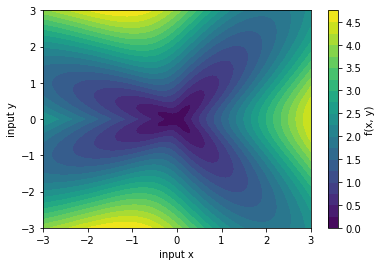

In [8]:
from matplotlib import pyplot as plt

def contour_plot():
    grid_x, grid_y = torch.meshgrid(torch.arange(-3, 3.1, 0.1), torch.arange(-3, 3.1, 0.1))
    outputs = f(grid_x, grid_y)
    
    plt.contourf(grid_x, grid_y, outputs, 20)
    plt.colorbar(label="f(x, y)")
    plt.xlabel("input x")
    plt.ylabel("input y")

contour_plot()
plt.show()

__Exercise__<br>
Your turn! Use autograd to differentiate `f` with respect to its two inputs.

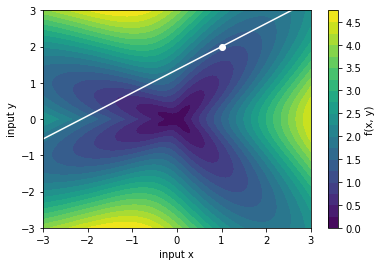

In [10]:
x = torch.tensor(1.0, requires_grad= True)
y = torch.tensor(2.0, requires_grad= True)

fval = f(x,y)

fval.backward()

# Compute the derivative of f at the point (x, y) with respect to x and y

df_dx = x.grad# TODO
df_dy = y.grad# TOD

def plot_tangent_line(x, y, df_dx, df_dy):
    x_points = torch.linspace(-3, 3, 100)
    y_points = -x.grad / y.grad * (x_points - x.detach()) + y.detach()
    plt.scatter(x.detach(), y.detach(), color='white')
    plt.plot(x_points, y_points, color='white')
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])


# Now play with x and y and check if your gradient computation worked
    
contour_plot()
plot_tangent_line(x, y, df_dx, df_dy)

plt.show()

---

# Advanced topics

### Leaves vs Nodes

*Advanced*

PyTorch's autograd mechanism differentiates between two types of tensors:
- __node variables__ are the result of a pytorch operation
- __leaf variables__ are directly created by a user

Later in the tutorial, we will use the `.is_leaf` property to differentiate between the two types.

In [0]:
A = torch.tensor([[1., 2.], [3., 4.]], requires_grad=True)
B = torch.tensor([[1., 2.], [3., 4.]], requires_grad=True) + 2  # B is the result of an operation (+)
C = 5 * A  # C is the result of an operation (*)
print("A.is_leaf :", A.is_leaf)
print("B.is_leaf :", B.is_leaf)
print("C.is_leaf :", C.is_leaf)

### Differentiating w.r.t. intermediate values: `.retain_grad()`

*Advanced*

When doing the backward pass, Autograd computes the gradient of the output with respect to every intermediate variables in the computation graph. However, by default, only gradients of variables that were **created by the user** (leaf) and **have the `requires_grad` property to True** are saved.

Indeed, most of the time when training a model you only need the gradient of a loss w.r.t. to your model parameters (which are leaf variables). 

In [0]:
A = torch.Tensor([[1, 2], [3, 4]])
A.requires_grad_()

B = 5 * (A + 3)
C = B.mean()

print("A.grad :", A.grad)
print("B.grad :", B.grad)
C.backward()
print("\n-- Backward --\n")
print("A.grad :", A.grad)
print("B.grad :", B.grad)

In [0]:
A = torch.Tensor([[1, 2], [3, 4]])
A.requires_grad_()

B = 5 * (A + 3)
B.retain_grad()  # <----- This line let us have access to gradient wrt. B after the backward pass
C = B.mean()


print("A.grad :", A.grad)
print("B.grad :", B.grad)
C.backward()
print("\n-- Backward --\n")
print("A.grad :", A.grad)
print("B.grad :", B.grad)

### Inspecting PyTorch's computation graph

*Advanced*


You can explore how PyTorch keeps track of history by inspecting the `tensor.grad_fn` argument:

In [0]:
print(y.grad_fn)
print(y.grad_fn.next_functions[0][0])
print(y.grad_fn.next_functions[0][0].next_functions[0][0])

Each value has a `grad_fn` corresponding to the operation that produced the value. 
Each operation's `grad_fn` points to its inputs through `next_functions`.
For each input, `next_functions` contains a tuple of the input's `grad_fn` and, if the operation had multiple outputs, an index of the relevant output.

In [0]:
# In our example, the final `add` operation has two inputs:
# - The first is the output of `multiplication`.
# - The second is a constant `4` for which we don't require a gradient.
y.grad_fn.next_functions

___

<!--NAVIGATION-->
# < [Basics](1-Basics.ipynb) | Autograd | [Optimization](3-Optimization.ipynb) >